/Users/yunlinz/Documents/Python/main/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


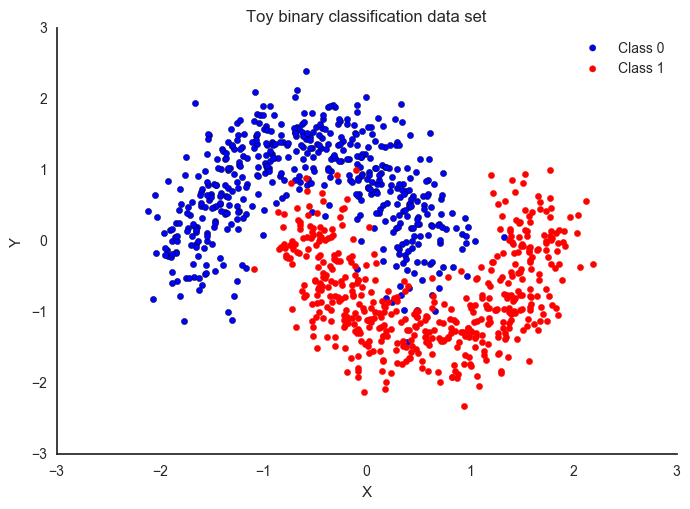

In [1]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)

fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [2]:
combined_data = np.concatenate((X, Y.reshape(-1,1)), axis = 1)
mask = np.random.binomial(1, 0.3, size=combined_data.shape).astype(bool)
masked_data = np.ma.masked_array(combined_data, mask=mask)

In [3]:
non_masked = combined_data[~mask[:,0] & ~mask[:,1] & ~mask[:,2]]
all_masked = combined_data[mask[:,0] & mask[:,1] & mask[:,2]]
x_masked = combined_data[mask[:,0] & ~mask[:,1]]
y_masked = combined_data[~mask[:,0] & mask[:,1]]
label_only = combined_data[mask[:,0] & mask[:,1] & ~mask[:,2]]
coord_only = combined_data[~mask[:,0] & ~mask[:,1] & mask[:,2]]

train_data = masked_data[~mask[:,0] | ~mask[:,1] | ~mask[:,2]]

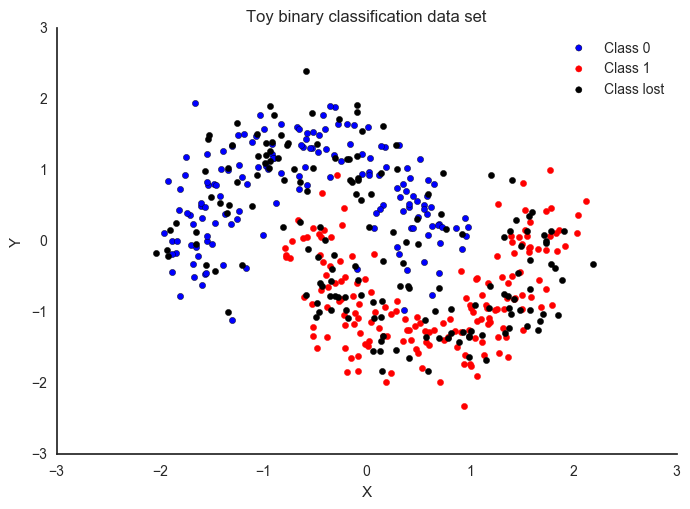

In [4]:
fig, ax = plt.subplots()
ax.scatter(non_masked[non_masked[:,2]==0, 0], non_masked[non_masked[:,2]==0, 1], label='Class 0')
ax.scatter(non_masked[non_masked[:,2]==1, 0], non_masked[non_masked[:,2]==1, 1], color='r', label='Class 1')
ax.scatter(coord_only[:,0], coord_only[:,1], color='black', label='Class lost')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [6]:
latent_size = 2

hidden_1 = 3
hidden_2 = 5
out = 4

v   = np.random.randn(train_data.shape[0], latent_size)
w_1 = np.random.randn(latent_size, hidden_1)
w_2 = np.random.randn(hidden_1, hidden_2)
w_3 = np.random.randn(hidden_2, out)

with pm.Model() as imputer:
    latent_v = pm.Normal('v', 0, sd=1, shape=(train_data.shape[0], latent_size), testval=v)
    weight_1 = pm.Normal('w_1', 0, sd=1, shape=(latent_size, hidden_1), testval=w_1)
    weight_2 = pm.Normal('w_2', 0, sd=1, shape=(hidden_1, hidden_2), testval=w_2)
    weight_3 = pm.Normal('w_3', 0, sd=1, shape=(hidden_2, out), testval=w_3)
    
    sigmas = pm.Normal('s', 1, 1, shape=2)
    
    act_1 = T.nnet.sigmoid(T.dot(latent_v, weight_1))
    act_2 = T.nnet.sigmoid(T.dot(act_1, weight_2))
    output = T.dot(act_2, weight_3)
    
    labels = pm.Bernoulli('label', act_2[:,0], observed=train_data[:,2])
    x_coords = pm.Normal('x', output[:,0], sd=sigmas[labels], observed=train_data[:,0])
    y_coords = pm.Normal('y', output[:,1], sd=sigmas[labels], observed=train_data[:,1])

In [13]:
from pymc3 import sample

with imputer:
    trace = sample(1000)


Assigned NUTS to v
Assigned NUTS to w_1
Assigned NUTS to w_2
Assigned NUTS to w_3
Assigned NUTS to s
Assigned BinaryGibbsMetropolis to label_missing
Assigned NUTS to x_missing
Assigned NUTS to y_missing
100%|██████████| 1000/1000 [45:06<00:00,  2.24it/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1276a0c90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x128e32410>]], dtype=object)

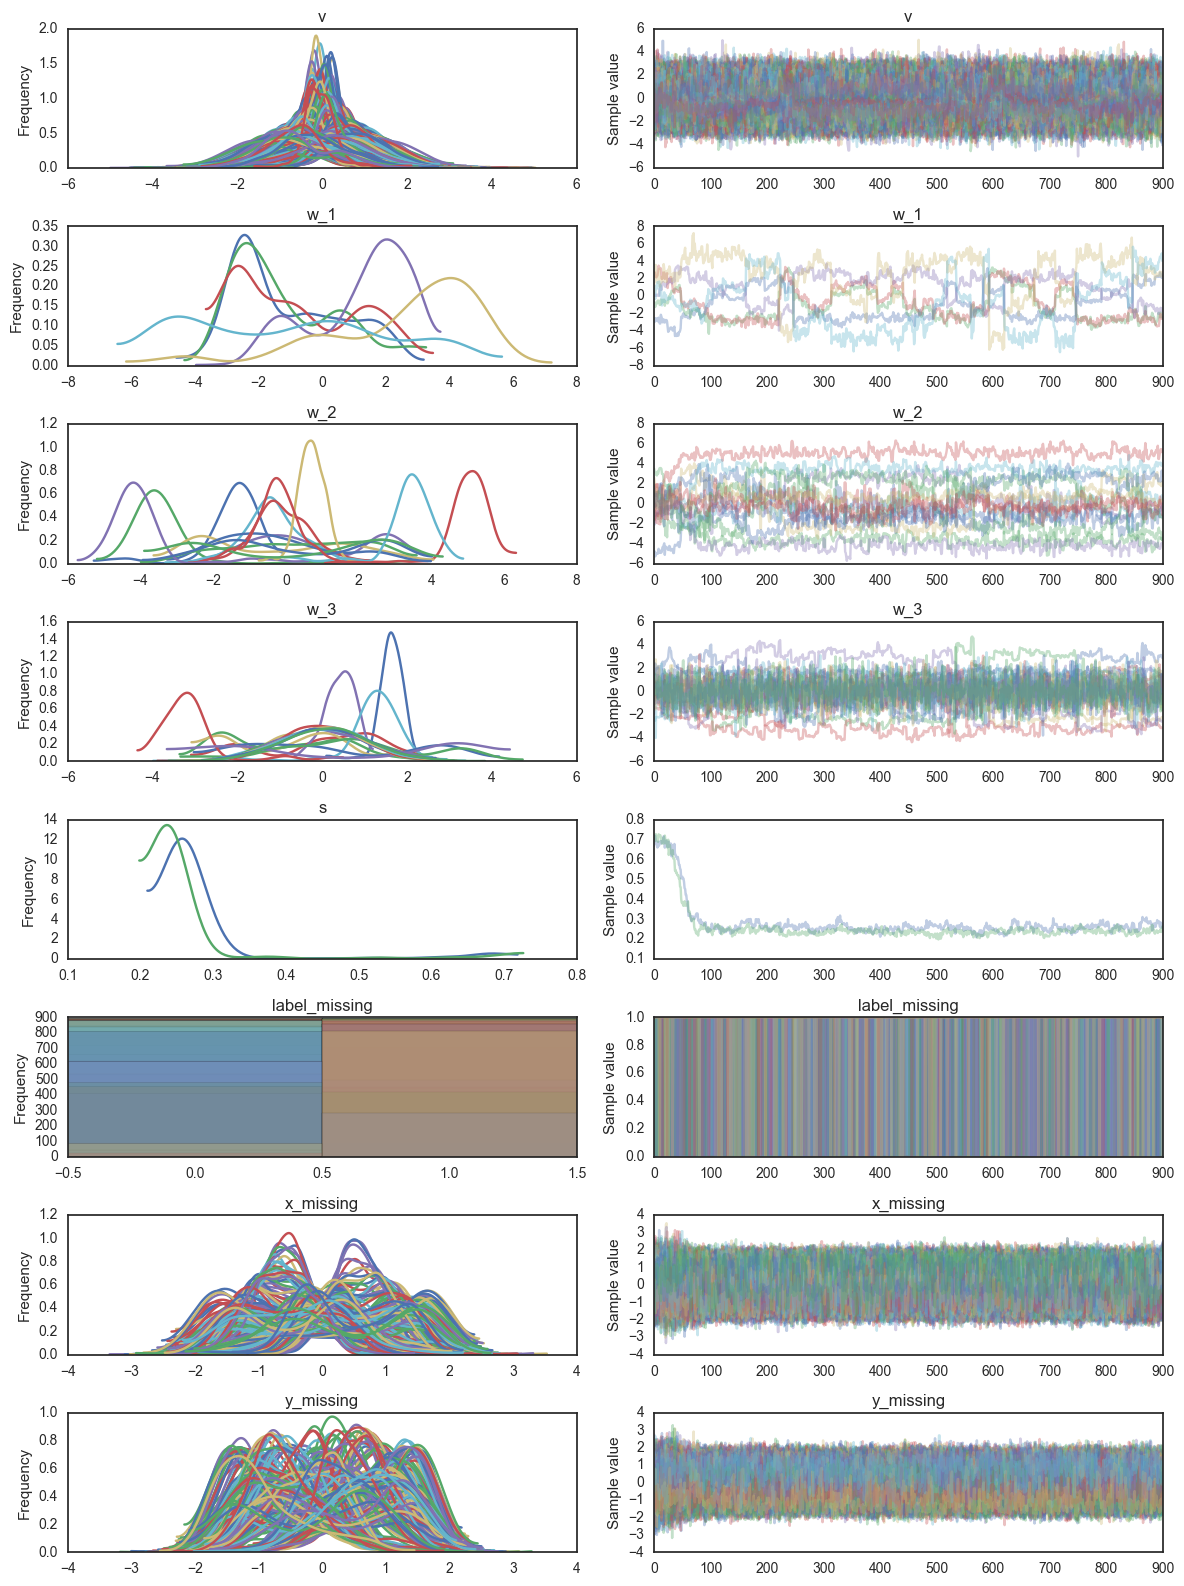

In [14]:
from pymc3 import traceplot

traceplot(trace[100:])

In [11]:
ppc = pm.sample_ppc(trace, samples=1, model=imputer, size=1)

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


In [75]:
for k in ppc.items():
    print(k)

('y', array([[ 0.14727768, -0.1765559 ,  0.8946667 , -0.24481249, -1.58751491,
         1.15728312, -0.30436684,  1.47014145,  2.0399177 , -1.60479073,
         0.983455  ,  0.28959728,  0.62680295, -0.87670225,  0.03139881,
        -0.66486726,  0.59965353,  0.33344267,  1.03984508, -0.42972874,
         0.28159778,  1.57983989,  0.13387705, -1.23091205, -0.50350764,
         0.0514795 , -1.36802228, -0.18053247, -2.10999428,  1.23745194,
        -1.65162039, -0.54354493,  1.3348033 , -0.14011509,  0.98014293,
         1.55324551, -0.77348661, -1.02203975, -1.63016179,  1.18997972,
        -0.55907421,  0.05353314,  0.95266356,  2.14374462, -0.86132884,
         1.17529308,  0.67380837,  1.32958208, -0.14574429, -0.21618477,
        -0.22870328,  0.02716224,  1.38917534, -0.38172569,  1.58191931,
         0.75865388, -0.48237387,  0.88378999,  0.81406981,  0.90007137,
         1.47937533,  0.97015542,  1.15605666, -0.16018125, -1.33440083,
        -0.28701709,  1.99336668, -0.32057906

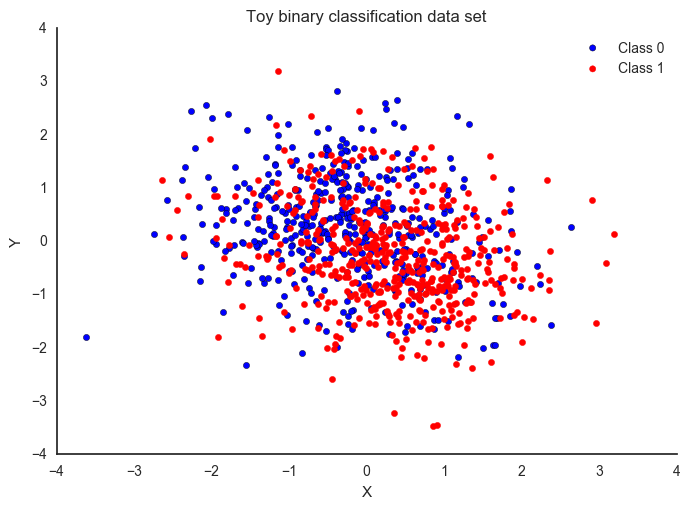

In [12]:
fig, ax = plt.subplots()
ax.scatter(ppc['x'].T[ppc['label'].T==0], ppc['y'].T[ppc['label'].T==0], label='Class 0')
ax.scatter(ppc['x'].T[ppc['label'].T==1], ppc['y'].T[ppc['label'].T==1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [81]:
sample_x = ppc['x'].T
sample_y = ppc['y'].T
sample_label = ppc['label'].T

In [82]:
print(sample_x.shape)
print(sample_y.shape)
print(sample_label.shape)

(863, 1)
(863, 1)
(863, 1)


In [84]:
sample_x

array([[ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [

In [9]:
from pymc3.stats import df_summary

In [10]:
df_summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
v__0_0,-0.264822,1.031345,0.103135,-2.297276,1.363654
v__0_1,-0.927815,0.669121,0.066912,-2.395323,0.295829
v__1_0,-0.263013,0.909493,0.090949,-1.822958,1.278007
v__1_1,-0.693038,0.716150,0.071615,-2.370697,0.563698
v__2_0,-0.009650,0.930518,0.093052,-1.666284,1.870742
v__2_1,0.279973,0.841453,0.084145,-1.566361,1.887671
v__3_0,0.195686,0.977633,0.097763,-1.687076,2.355584
v__3_1,-0.136974,0.728618,0.072862,-1.788361,1.306670
v__4_0,-0.043457,0.922572,0.092257,-1.515758,1.897073
v__4_1,-0.514688,0.621942,0.062194,-1.806972,0.615300
